
# Group GEMM
This group gemm kernel launches a fixed number of CTA to compute a group
of gemms. The scheduling is static and we do it on device.


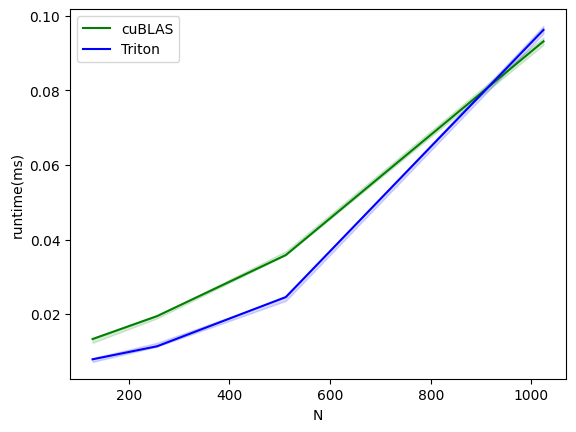

group-gemm-performance:
        N    cuBLAS    Triton
0   128.0  0.013312  0.007872
1   256.0  0.019456  0.011360
2   512.0  0.035840  0.024576
3  1024.0  0.093184  0.096256


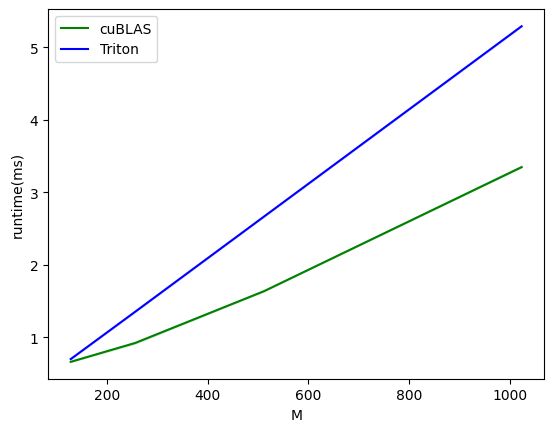

group-gemm-performance-m-8192-k-8192:
        M    cuBLAS    Triton
0   128.0  0.663552  0.701440
1   256.0  0.923648  1.353728
2   512.0  1.637376  2.665824
3  1024.0  3.347456  5.289984


In [2]:
# Copyright (c) 2023 - 2025 NVIDIA Corporation & Affiliates. All rights reserved.
#
# Permission is hereby granted, free of charge, to any person obtaining
# a copy of this software and associated documentation files
# (the "Software"), to deal in the Software without restriction,
# including without limitation the rights to use, copy, modify, merge,
# publish, distribute, sublicense, and/or sell copies of the Software,
# and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
#
# The above copyright notice and this permission notice shall be
# included in all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
# EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
# MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.
# IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY
# CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT,
# TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE
# SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

from typing import Optional
import torch

import triton
import triton.language as tl

# DEVICE = triton.runtime.driver.active.get_active_torch_device()
DEVICE = torch.device("cuda:0")


def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda" 


def supports_tma():
    return is_cuda() and torch.cuda.get_device_capability()[0] >= 9


def num_sms():
    if is_cuda():
        return torch.cuda.get_device_properties("cuda").multi_processor_count
    return 148


@triton.autotune(
    configs=[
        triton.Config({
            'BLOCK_SIZE_M': 128,
            'BLOCK_SIZE_N': 128,
            'BLOCK_SIZE_K': 32,
            'NUM_SM': 84,
        }),
        triton.Config({
            'BLOCK_SIZE_M': 128,
            'BLOCK_SIZE_N': 128,
            'BLOCK_SIZE_K': 32,
            'NUM_SM': 128,
        }),
        triton.Config({
            'BLOCK_SIZE_M': 64,
            'BLOCK_SIZE_N': 64,
            'BLOCK_SIZE_K': 32,
            'NUM_SM': 84,
        }),
        triton.Config({
            'BLOCK_SIZE_M': 64,
            'BLOCK_SIZE_N': 64,
            'BLOCK_SIZE_K': 32,
            'NUM_SM': 128,
        }),
        triton.Config({
            'BLOCK_SIZE_M': 128,
            'BLOCK_SIZE_N': 128,
            'BLOCK_SIZE_K': 64,
            'NUM_SM': num_sms(),
        }),
        triton.Config({
            'BLOCK_SIZE_M': 64,
            'BLOCK_SIZE_N': 128,
            'BLOCK_SIZE_K': 64,
            'NUM_SM': num_sms(),
        }),
    ],
    key=['group_size'],
)
@triton.jit
def grouped_matmul_kernel(
    # device tensor of matrices pointers
    group_a_ptrs,
    group_b_ptrs,
    group_c_ptrs,
    # device tensor of gemm sizes. its shape is [group_size, 3]
    # dim 0 is group_size, dim 1 is the values of <M, N, K> of each gemm
    group_gemm_sizes,
    # device tensor of leading dimension sizes. its shape is [group_size, 3]
    # dim 0 is group_size, dim 1 is the values of <lda, ldb, ldc> of each gemm
    g_lds,
    # number of gemms
    group_size,
    # number of virtual SM
    NUM_SM: tl.constexpr,
    # tile sizes
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
):
    tile_idx = tl.program_id(0)
    last_problem_end = 0
    for g in range(group_size):
        # get the gemm size of the current problem
        gm = tl.load(group_gemm_sizes + g * 3)
        gn = tl.load(group_gemm_sizes + g * 3 + 1)
        gk = tl.load(group_gemm_sizes + g * 3 + 2)
        num_m_tiles = tl.cdiv(gm, BLOCK_SIZE_M)
        num_n_tiles = tl.cdiv(gn, BLOCK_SIZE_N)
        num_tiles = num_m_tiles * num_n_tiles
        # iterate through the tiles in the current gemm problem
        while (tile_idx >= last_problem_end and tile_idx < last_problem_end + num_tiles):
            # pick up a tile from the current gemm problem
            k = gk
            lda = tl.load(g_lds + g * 3)
            ldb = tl.load(g_lds + g * 3 + 1)
            ldc = tl.load(g_lds + g * 3 + 2)
            a_ptr = tl.load(group_a_ptrs + g).to(tl.pointer_type(tl.float16))
            b_ptr = tl.load(group_b_ptrs + g).to(tl.pointer_type(tl.float16))
            c_ptr = tl.load(group_c_ptrs + g).to(tl.pointer_type(tl.float16))
            # figure out tile coordinates
            tile_idx_in_gemm = tile_idx - last_problem_end
            tile_m_idx = tile_idx_in_gemm // num_n_tiles
            tile_n_idx = tile_idx_in_gemm % num_n_tiles

            # do regular gemm here
            offs_am = tile_m_idx * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
            offs_bn = tile_n_idx * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
            offs_k = tl.arange(0, BLOCK_SIZE_K)
            a_ptrs = a_ptr + offs_am[:, None] * lda + offs_k[None, :]
            b_ptrs = b_ptr + offs_k[:, None] * ldb + offs_bn[None, :]
            accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
            for kk in range(0, tl.cdiv(k, BLOCK_SIZE_K)):
                # hint to Triton compiler to do proper loop pipelining
                tl.multiple_of(a_ptrs, [16, 16])
                tl.multiple_of(b_ptrs, [16, 16])
                # assume full tile for now
                a = tl.load(a_ptrs)
                b = tl.load(b_ptrs)
                accumulator += tl.dot(a, b)
                a_ptrs += BLOCK_SIZE_K
                b_ptrs += BLOCK_SIZE_K * ldb
            c = accumulator.to(tl.float16)

            offs_cm = tile_m_idx * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
            offs_cn = tile_n_idx * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
            c_ptrs = c_ptr + ldc * offs_cm[:, None] + offs_cn[None, :]

            # assumes full tile for now
            tl.store(c_ptrs, c)

            # go to the next tile by advancing NUM_SM
            tile_idx += NUM_SM

        # get ready to go to the next gemm problem
        last_problem_end = last_problem_end + num_tiles


def group_gemm_fn(group_A, group_B):
    assert len(group_A) == len(group_B)
    group_size = len(group_A)

    A_addrs = []
    B_addrs = []
    C_addrs = []
    g_sizes = []
    g_lds = []
    group_C = []
    for i in range(group_size):
        A = group_A[i]
        B = group_B[i]
        assert A.shape[1] == B.shape[0]
        M, K = A.shape
        K, N = B.shape
        C = torch.empty((M, N), device=DEVICE, dtype=A.dtype)
        group_C.append(C)
        A_addrs.append(A.data_ptr())
        B_addrs.append(B.data_ptr())
        C_addrs.append(C.data_ptr())
        g_sizes += [M, N, K]
        g_lds += [A.stride(0), B.stride(0), C.stride(0)]

    # note these are device tensors
    d_a_ptrs = torch.tensor(A_addrs, device=DEVICE)
    d_b_ptrs = torch.tensor(B_addrs, device=DEVICE)
    d_c_ptrs = torch.tensor(C_addrs, device=DEVICE)
    d_g_sizes = torch.tensor(g_sizes, dtype=torch.int32, device=DEVICE)
    d_g_lds = torch.tensor(g_lds, dtype=torch.int32, device=DEVICE)
    # we use a fixed number of CTA, and it's auto-tunable
    grid = lambda META: (META['NUM_SM'], )
    grouped_matmul_kernel[grid](
        d_a_ptrs,
        d_b_ptrs,
        d_c_ptrs,
        d_g_sizes,
        d_g_lds,
        group_size,
    )

    return group_C


tma_configs = [
    triton.Config({'BLOCK_SIZE_M': BM, 'BLOCK_SIZE_N': BN, 'BLOCK_SIZE_K' : BK}, num_stages=s, num_warps=w) \
    for BM in [128]\
    for BN in [128, 256]\
    for BK in [64, 128]\
    for s in ([3, 4])\
    for w in [4, 8]\
]


@triton.autotune(
    tma_configs,
    key=['group_a_ptrs', 'group_b_ptrs', 'group_c_ptrs', 'group_size'],
)
@triton.jit
def grouped_matmul_tma_kernel(
    # device tensor of matrices pointers
    group_a_ptrs,
    group_b_ptrs,
    group_c_ptrs,
    # device tensor of gemm sizes. its shape is [group_size, 3]
    # dim 0 is group_size, dim 1 is the values of <M, N, K> of each gemm
    group_gemm_sizes,
    # device tensor of leading dimension sizes. its shape is [group_size, 3]
    # dim 0 is group_size, dim 1 is the values of <lda, ldb, ldc> of each gemm
    g_lds,
    # number of gemms
    group_size,
    # number of virtual SM
    NUM_SM: tl.constexpr,
    # tile sizes
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
    # is the output FP8 or FP16
    FP8: tl.constexpr,
):
    dtype = tl.float8e4nv if FP8 else tl.float16
    tile_idx = tl.program_id(0)
    last_problem_end = 0
    for g in range(group_size):
        # get the gemm size of the current problem
        gm = tl.load(group_gemm_sizes + g * 3)
        gn = tl.load(group_gemm_sizes + g * 3 + 1)
        gk = tl.load(group_gemm_sizes + g * 3 + 2)
        num_m_tiles = tl.cdiv(gm, BLOCK_SIZE_M)
        num_n_tiles = tl.cdiv(gn, BLOCK_SIZE_N)
        num_tiles = num_m_tiles * num_n_tiles
        if tile_idx >= last_problem_end and tile_idx < last_problem_end + num_tiles:
            # pick up a tile from the current gemm problem
            lda = tl.load(g_lds + g * 3)
            ldb = tl.load(g_lds + g * 3 + 1)
            ldc = tl.load(g_lds + g * 3 + 2)

            a_ptr = tl.load(group_a_ptrs + g).to(tl.pointer_type(dtype))
            b_ptr = tl.load(group_b_ptrs + g).to(tl.pointer_type(dtype))
            c_ptr = tl.load(group_c_ptrs + g).to(tl.pointer_type(dtype))

            a_desc = tl.make_tensor_descriptor(
                a_ptr,
                shape=[gm, gk],
                strides=[lda, 1],
                block_shape=[BLOCK_SIZE_M, BLOCK_SIZE_K],
            )

            b_desc = tl.make_tensor_descriptor(
                b_ptr,
                shape=[gn, gk],
                strides=[ldb, 1],
                block_shape=[BLOCK_SIZE_N, BLOCK_SIZE_K],
            )
            c_desc = tl.make_tensor_descriptor(
                c_ptr,
                shape=[gm, gn],
                strides=[ldc, 1],
                block_shape=[BLOCK_SIZE_M, BLOCK_SIZE_N],
            )

            # iterate through the tiles in the current gemm problem
            while (tile_idx >= last_problem_end and tile_idx < last_problem_end + num_tiles):
                k = gk
                # figure out tile coordinates
                tile_idx_in_gemm = tile_idx - last_problem_end
                tile_m_idx = tile_idx_in_gemm // num_n_tiles
                tile_n_idx = tile_idx_in_gemm % num_n_tiles

                # do regular gemm here
                offs_am = tile_m_idx * BLOCK_SIZE_M
                offs_bn = tile_n_idx * BLOCK_SIZE_N

                accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
                for kk in range(0, tl.cdiv(k, BLOCK_SIZE_K)):
                    a = a_desc.load([offs_am, kk * BLOCK_SIZE_K])
                    b = b_desc.load([offs_bn, kk * BLOCK_SIZE_K])
                    accumulator += tl.dot(a, b.T)

                offs_cm = tile_m_idx * BLOCK_SIZE_M
                offs_cn = tile_n_idx * BLOCK_SIZE_N

                c = accumulator.to(dtype)
                c_desc.store([offs_cm, offs_cn], c)

                # go to the next tile by advancing NUM_SM
                tile_idx += NUM_SM

        # get ready to go to the next gemm problem
        last_problem_end = last_problem_end + num_tiles


def group_gemm_tma_fn(group_A, group_B):

    assert supports_tma()

    assert len(group_A) == len(group_B)
    group_size = len(group_A)

    A_addrs = []
    B_addrs = []
    C_addrs = []
    g_sizes = []
    g_lds = []
    group_C = []
    for i in range(group_size):
        A = group_A[i]
        B = group_B[i]
        assert A.shape[1] == B.shape[1]
        M, K = A.shape
        N, K = B.shape
        C = torch.empty((M, N), device=DEVICE, dtype=A.dtype)
        group_C.append(C)
        A_addrs.append(A.data_ptr())
        B_addrs.append(B.data_ptr())
        C_addrs.append(C.data_ptr())
        g_sizes += [M, N, K]
        g_lds += [A.stride(0), B.stride(0), C.stride(0)]
    # note these are device tensors
    d_a_ptrs = torch.tensor(A_addrs, device=DEVICE)
    d_b_ptrs = torch.tensor(B_addrs, device=DEVICE)
    d_c_ptrs = torch.tensor(C_addrs, device=DEVICE)
    d_g_sizes = torch.tensor(g_sizes, dtype=torch.int32, device=DEVICE)
    d_g_lds = torch.tensor(g_lds, dtype=torch.int32, device=DEVICE)

    # we use a fixed number of CTA, and it's auto-tunable

    # TMA descriptors require a global memory allocation
    def alloc_fn(size: int, alignment: int, stream: Optional[int]):
        return torch.empty(size, device="cuda", dtype=torch.int8)

    triton.set_allocator(alloc_fn)

    grid = lambda META: (META['NUM_SM'], )
    grouped_matmul_tma_kernel[grid](d_a_ptrs, d_b_ptrs, d_c_ptrs, d_g_sizes, d_g_lds, group_size,
                                    FP8=torch.float8_e4m3fn == group_A[0].dtype, NUM_SM=num_sms())
    return group_C


group_m = [1024, 512, 256, 128]
group_n = [1024, 512, 256, 128]
group_k = [1024, 512, 256, 128]
group_A = []
group_B = []
group_B_T = []
assert len(group_m) == len(group_n)
assert len(group_n) == len(group_k)
group_size = len(group_m)
for i in range(group_size):
    M = group_m[i]
    N = group_n[i]
    K = group_k[i]
    A = torch.rand((M, K), device=DEVICE, dtype=torch.float16)
    B = torch.rand((K, N), device=DEVICE, dtype=torch.float16)
    B_T = B.T.contiguous()
    group_A.append(A)
    group_B.append(B)
    group_B_T.append(B_T)

tri_out = group_gemm_fn(group_A, group_B)
ref_out = [torch.matmul(a, b) for a, b in zip(group_A, group_B)]
for i in range(group_size):
    assert torch.allclose(ref_out[i], tri_out[i], atol=1e-2, rtol=1e-2)

if supports_tma():
    tri_tma_out = group_gemm_tma_fn(group_A, group_B_T)
    for i in range(group_size):
        assert torch.allclose(ref_out[i], tri_tma_out[i], atol=1e-2, rtol=1e-2)


# only launch the kernel, no tensor preparation here to remove all overhead
def triton_perf_fn(a_ptrs, b_ptrs, c_ptrs, sizes, lds, group_size):
    grid = lambda META: (META['NUM_SM'], )
    grouped_matmul_kernel[grid](
        a_ptrs,
        b_ptrs,
        c_ptrs,
        sizes,
        lds,
        group_size,
    )


def triton_tma_perf_fn(a_ptrs, b_ptrs, c_ptrs, sizes, lds, group_size, dtype):
    grid = lambda META: (META['NUM_SM'], )
    grouped_matmul_tma_kernel[grid](a_ptrs, b_ptrs, c_ptrs, sizes, lds, group_size, FP8=torch.float8_e4m3fn == dtype,
                                    NUM_SM=num_sms())


def torch_perf_fn(group_A, group_B):
    for a, b in zip(group_A, group_B):
        torch.matmul(a, b)


@triton.testing.perf_report(
    triton.testing.Benchmark(
        # argument names to use as an x-axis for the plot
        x_names=['N'],
        x_vals=[2**i for i in range(7, 11)],  # different possible values for `x_name`
        line_arg='provider',
        # argument name whose value corresponds to a different line in the plot
        # possible values for `line_arg``
        line_vals=['cublas', 'triton'] + (['triton-tma'] if supports_tma() else []),
        # label name for the lines
        line_names=["cuBLAS", "Triton"] + (['Triton + TMA'] if supports_tma() else []),
        # line styles
        styles=[('green', '-'), ('blue', '-')] + ([('red', '-')] if supports_tma() else []),
        ylabel="runtime(ms)",  # label name for the y-axis
        plot_name="group-gemm-performance",
        # name for the plot. Used also as a file name for saving the plot.
        args={},
    ))
def benchmark_square_matrices(N, provider):
    group_size = 4
    group_A = []
    group_B = []
    group_B_T = []
    A_addrs = []
    B_addrs = []
    B_T_addrs = []
    C_addrs = []
    g_sizes = []
    g_lds = []
    group_C = []
    for i in range(group_size):
        A = torch.rand((N, N), device=DEVICE, dtype=torch.float16)
        B = torch.rand((N, N), device=DEVICE, dtype=torch.float16)
        C = torch.empty((N, N), device=DEVICE, dtype=torch.float16)
        B_T = B.T.contiguous()
        group_A.append(A)
        group_B.append(B)
        group_B_T.append(B_T)
        group_C.append(C)
        A_addrs.append(A.data_ptr())
        B_addrs.append(B.data_ptr())
        B_T_addrs.append(B_T.data_ptr())
        C_addrs.append(C.data_ptr())
        g_sizes += [N, N, N]
        g_lds += [N, N, N]

    d_a_ptrs = torch.tensor(A_addrs, device=DEVICE)
    d_b_ptrs = torch.tensor(B_addrs, device=DEVICE)
    d_b_t_ptrs = torch.tensor(B_T_addrs, device=DEVICE)
    d_c_ptrs = torch.tensor(C_addrs, device=DEVICE)
    d_g_sizes = torch.tensor(g_sizes, dtype=torch.int32, device=DEVICE)
    d_g_lds = torch.tensor(g_lds, dtype=torch.int32, device=DEVICE)

    quantiles = [0.5, 0.2, 0.8]
    if provider == 'cublas':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch_perf_fn(group_A, group_B), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: triton_perf_fn(d_a_ptrs, d_b_ptrs, d_c_ptrs, d_g_sizes, d_g_lds, group_size), quantiles=quantiles)
    if provider == 'triton-tma':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: triton_tma_perf_fn(d_a_ptrs, d_b_t_ptrs, d_c_ptrs, d_g_sizes, d_g_lds, group_size, dtype=torch.
                                       float16), quantiles=quantiles)
    return ms, max_ms, min_ms


@triton.testing.perf_report(
    triton.testing.Benchmark(
        # argument names to use as an x-axis for the plot
        x_names=['M'],
        x_vals=[2**i for i in range(7, 11)],  # different possible values for `x_name`
        line_arg='provider',
        # argument name whose value corresponds to a different line in the plot
        # possible values for `line_arg``
        line_vals=['cublas', 'triton'] + (['triton-tma'] if supports_tma() else []),
        # label name for the lines
        line_names=["cuBLAS", "Triton"] + (['Triton + TMA'] if supports_tma() else []),
        # line styles
        styles=[('green', '-'), ('blue', '-')] + ([('red', '-')] if supports_tma() else []),
        ylabel="runtime(ms)",  # label name for the y-axis
        plot_name="group-gemm-performance-m-8192-k-8192",
        # name for the plot. Used also as a file name for saving the plot.
        args={},
    ))
def benchmark_batches(M, provider):
    N = 8192
    K = 8192
    group_size = 4
    group_A = []
    group_B = []
    group_B_T = []
    A_addrs = []
    B_addrs = []
    B_T_addrs = []
    C_addrs = []
    g_sizes = []
    g_lds = []
    g_T_lds = []
    group_C = []
    for i in range(group_size):
        A = torch.rand((M, K), device=DEVICE, dtype=torch.float16)
        B = torch.rand((K, N), device=DEVICE, dtype=torch.float16)
        C = torch.empty((M, N), device=DEVICE, dtype=torch.float16)
        B_T = B.T.contiguous()
        group_A.append(A)
        group_B.append(B)
        group_B_T.append(B_T)
        group_C.append(C)
        A_addrs.append(A.data_ptr())
        B_addrs.append(B.data_ptr())
        B_T_addrs.append(B_T.data_ptr())
        C_addrs.append(C.data_ptr())
        g_sizes += [M, N, K]
        g_lds += [A.stride(0), B.stride(0), C.stride(0)]
        g_T_lds += [A.stride(0), B_T.stride(0), C.stride(0)]

    d_a_ptrs = torch.tensor(A_addrs, device=DEVICE)
    d_b_ptrs = torch.tensor(B_addrs, device=DEVICE)
    d_b_t_ptrs = torch.tensor(B_T_addrs, device=DEVICE)
    d_c_ptrs = torch.tensor(C_addrs, device=DEVICE)
    d_g_sizes = torch.tensor(g_sizes, dtype=torch.int32, device=DEVICE)
    d_g_lds = torch.tensor(g_lds, dtype=torch.int32, device=DEVICE)
    d_g_t_lds = torch.tensor(g_T_lds, dtype=torch.int32, device=DEVICE)

    quantiles = [0.5, 0.2, 0.8]
    if provider == 'cublas':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch_perf_fn(group_A, group_B), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: triton_perf_fn(d_a_ptrs, d_b_ptrs, d_c_ptrs, d_g_sizes, d_g_lds, group_size), quantiles=quantiles)
    if provider == 'triton-tma':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: triton_tma_perf_fn(d_a_ptrs, d_b_t_ptrs, d_c_ptrs, d_g_sizes, d_g_t_lds, group_size, dtype=torch.
                                       float16), quantiles=quantiles)
    return ms, max_ms, min_ms


benchmark_square_matrices.run(show_plots=True, print_data=True)
benchmark_batches.run(show_plots=True, print_data=True)

In [4]:
# is_cuda()
triton.runtime.driver.active.get_current_target()

GPUTarget(backend='cuda', arch=89, warp_size=32)